In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
from HPA_CC.data.dataset import RefCLSDM, RefImDM, load_labels
from HPA_CC.models.train import find_checkpoint_file, ClassifierLit, PseudoRegressorLit
from HPA_CC.models.models import PseudoRegressor
classes = ["M-G1", "G1", "S-G2", "G2"]

In [3]:
# model_name = "HPA DINO Classifier"
# model_hash = "1gu6u2qu" # hash of the model to use
model_name = "HPA DINO Angle Regressor"
model_hash = "u0livnza"
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
log_dirs_home = Path("/data/ishang/pseudotime_pred/")
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = True # were intensity statistics added to the embedding? (not used from conv)
label_type = "angle" # "phase", "angle", or "pseudotime"
scope = False # Only used for phase
split = (0.64, 0.16, 0.2)
data_dir = Path("/data/ishang/FUCCI-dataset-well")
data_name = "minimal"
device = "cuda:0"

In [4]:
if repr_type == "conv":
    dataset = RefImDM(data_dir, data_name, 32, 1, split, label_type, scope)
else:
    dataset = RefCLSDM(data_dir, data_name, 32, 1, split, (repr_type == "hpa_dino"), label_type, scope, int_stats)
phase_labels = load_labels("phase", data_dir, data_name, scope)

Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/intensity_distributions_minimal.pt
X shape: torch.Size([31732, 1536])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_angles.pt
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
X shape: torch.Size([31732, 2048])
Y shape: torch.Size([31732])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase.pt


In [5]:
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
if label_type == "phase":
    model = ClassifierLit.load_from_checkpoint(checkpoint_file)
else:
    model = PseudoRegressorLit.load_from_checkpoint(checkpoint_file)
model.to(device)
model.eval()


PseudoRegressorLit(
  (model): OptimizedModule(
    (_orig_mod): PseudoRegressor(
      (model): Sequential(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=4096, out_features=4096, bias=True)
        (4): GELU(approximate='none')
        (5): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Linear(in_features=4096, out_features=4096, bias=True)
        (7): GELU(approximate='none')
        (8): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Linear(in_features=4096, out_features=4096, bias=True)
        (10): GELU(approximate='none')
        (11): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): Linear(in_features=4096, out_features=1, bias=True)
      )
    )
  )
)

In [6]:
preds_list = []
with torch.no_grad():
    for batch in iter(dataset.test_dataloader()):
        x, y = batch
        x = x.to(device)
        preds_list.append(model(x).cpu())
preds_test = torch.cat(preds_list, dim=0).numpy()
labels_test = dataset.dataset.Y[dataset.split_indices["test"]]
phase_labels_test = phase_labels[dataset.split_indices["test"]]
print(preds_test.shape, labels_test.shape, phase_labels_test.shape)

/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


(6346, 1) torch.Size([6346]) torch.Size([6346, 4])


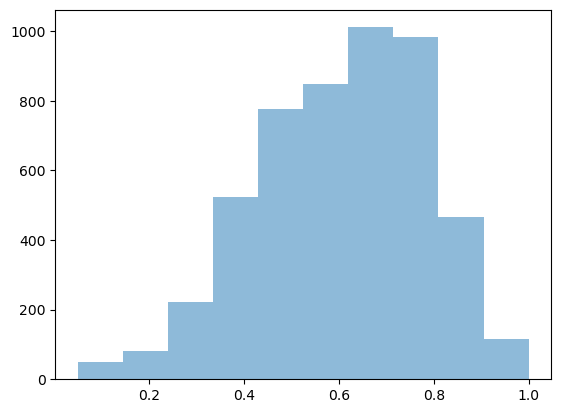

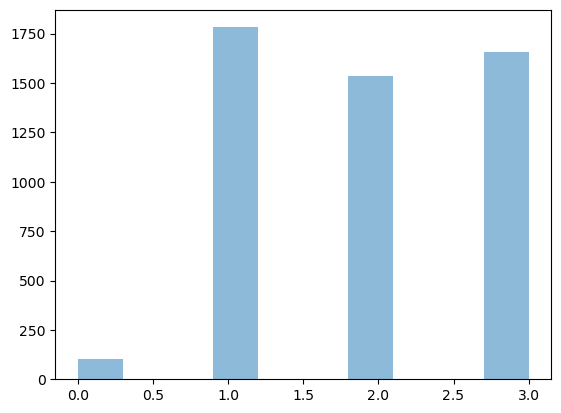

<Figure size 640x480 with 0 Axes>

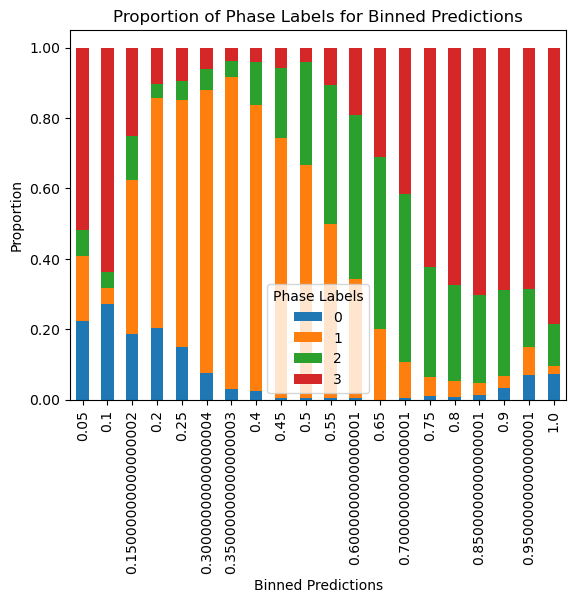

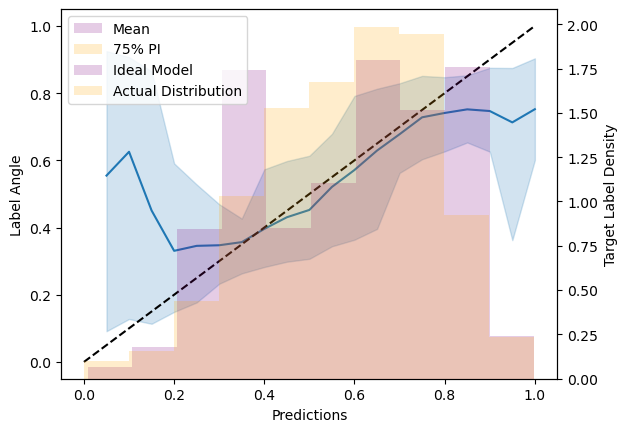

In [44]:
if label_type != "phase":
    preds_list = []
    with torch.no_grad():
        for batch in iter(dataset.val_dataloader()):
            x, y = batch
            x = x.to(device)
            preds_list.append(model(x).cpu())

    preds_val = torch.cat(preds_list, dim=0)
    preds_val = PseudoRegressor.angle_to_pseudo(preds_val).numpy().flatten()
    labels_val = dataset.dataset.Y[dataset.split_indices["val"]]
    phase_labels_val = phase_labels[dataset.split_indices["val"]]
    phase_labels_val = np.argmax(phase_labels_val, axis=1)

    bins = np.linspace(0, 1, 21)
    binned_preds_val = np.digitize(preds_val, bins)
    plt.hist(bins[binned_preds_val], alpha=0.5, label='Predictions')
    plt.show()
    plt.clf()

    plt.hist(phase_labels_val, alpha=0.5, label='Predictions')
    plt.show()
    plt.clf()

    df = pd.DataFrame({'Binned Predictions': bins[binned_preds_val], 'Phase Labels': phase_labels_val})
    crosstab = pd.crosstab(df['Binned Predictions'], df['Phase Labels'])
    crosstab_normalized = crosstab.apply(lambda row: row / row.sum(), axis=1)
    crosstab_normalized.plot.bar(stacked=True)
    plt.xlabel('Binned Predictions')
    plt.ylabel('Proportion')
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    plt.title('Proportion of Phase Labels for Binned Predictions')
    plt.legend(title='Phase Labels')
    plt.show()

    int_size = 75
    df = pd.DataFrame({'Predictions': bins[binned_preds_val], 'Label Angle': labels_val})
    ax = sns.lineplot(data=df, x='Predictions', y='Label Angle', errorbar=('pi', int_size))
    x = np.linspace(0, 1, 100)
    ax.plot(x, x, color='black', linestyle='--')
    ax2 = ax.twinx()
    angle_labels_val = PseudoRegressor.angle_to_pseudo(torch.Tensor(labels_val)).numpy()
    ax2.hist(labels_val, alpha=0.2, label='Phase Labels', color='purple', density=True)
    ax2.hist(preds_val, alpha=0.2, label='Phase Labels', color='orange', density=True)
    ax2.set_ylabel('Target Label Density')
    plt.legend(['Mean', f'{int_size}% PI', 'Ideal Model', 'Actual Distribution', 'Predicted Distribution'])
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))


In [8]:
if label_type == "phase":
    preds_test = np.argmax(preds_test, axis=1)
    labels_test = np.argmax(labels_test, axis=1)
    print(preds_test.shape, labels_test.shape)
elif label_type == "angle":
    NUM_COMPONENTS, NUM_CLASSES = 7, 4
    # Fit the Bayesian GMM to the angular distributions
    if scope:
        scope_names_list = []
        for scope, n_cell in zip(scope_names, cells_per_well):
            scope_names_list.extend([scope] * n_cell)
        # these are set in the pseudotime_labels.ipynb notebook at the botoom
        scope_gmms = pkl.load(open(OUTPUT_DIR / "scope_gmms.pkl", "rb"))
        groupings = pkl.load(open(OUTPUT_DIR / "groupings.pkl", "rb"))
        from HPA_CC.utils.pseudotime import comp_to_class

        class_likelihoods = []
        for i, (scope, angle) in tqdm(enumerate(zip(scope_names_list, std_full_angles)), desc="Calculating class likelihoods"):
            gmm = scope_gmms[scope]
            group = groupings[scope]
            sample_class_likelihoods = np.zeros((1, NUM_CLASSES))
            angles = np.array([angle])
            likelihoods = gmm._estimate_weighted_log_prob(angles.reshape(-1, 1))
            for comp in range(gmm.n_components):
                cell_idx = sample_class_likelihoods[:, comp_to_class(comp, gmm, group)]
                sample_class_likelihoods[:, comp_to_class(comp, gmm, group)] = np.log(np.exp(cell_idx) + np.exp(likelihoods[:, comp]))
            class_likelihoods.append(sample_class_likelihoods)
        class_likelihoods = np.concatenate(class_likelihoods)
        print(class_likelihoods.shape)
    else:
        gmm = BayesianGaussianMixture(n_components=7, covariance_type='full', n_init=10)
        gmm.fit(std_full_angles.reshape(-1, 1))

        def full_comp_to_class(comp):
            sorted_idx = list(np.argsort(gmm.means_.flatten()))
            if sorted_idx.index(comp) == 0:
                return 0
            return ((sorted_idx.index(comp) - 1) // 2) + 1

        class_likelihoods = np.zeros((len(std_full_std_int), NUM_CLASSES))
        likelihoods = gmm._estimate_weighted_log_prob(std_full_angles.reshape(-1, 1))
        for comp in range(gmm.n_components):
            cell_idx = class_likelihoods[:, full_comp_to_class(comp)]
            class_likelihoods[:, full_comp_to_class(comp)] = np.log(np.exp(cell_idx) + np.exp(likelihoods[:, comp]))

    pseudotime_class = np.argmax(class_likelihoods, axis=1)

NameError: name 'BayesianGaussianMixture' is not defined

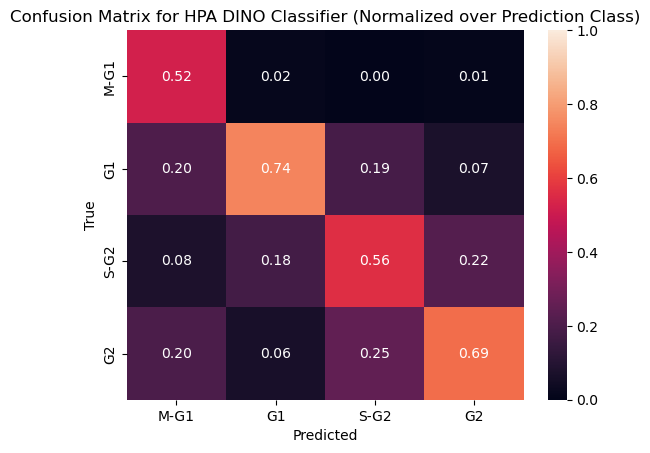

In [ ]:
filler = np.arange(len(classes))
preds_ = np.concatenate((preds_test, filler))
labels_ = np.concatenate((labels_test, filler))
cm = confusion_matrix(labels_, preds_).astype(np.float32)
cm = cm - np.identity(len(classes))
cm = cm / np.sum(cm, axis=0, keepdims=True)
ax = sns.heatmap(cm, annot=True, fmt=".2f", vmin=0, vmax=1.0)
ax.set_xlabel("Predicted")
ax.xaxis.set_ticklabels(classes)
ax.set_ylabel("True")
ax.yaxis.set_ticklabels(classes)
plt.title(f"Confusion Matrix for {model_name} (Normalized over Prediction Class)")
plt.show()